# 순환 신경망으로 IMDB 리뷰 분류하기

## IMDB 리뷰 데이터셋

In [1]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [3]:
# 첫번째 리뷰의 길이(토큰 수)

print(len(train_input[0])) 

218


In [4]:
# num_words=500으로 지정했기 때문에 어휘 사전에는 500개의 단어만 들어가 있다.
# 따라서 없는것은 2로 표시된다.

print(train_input[0]) 

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [5]:
# 부정0 긍정1
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [6]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size =0.2, random_state=42)

In [7]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

print(np.mean(lengths), np.median(lengths))

# 리뷰의 평균 단어 개수는 239개 중간값이 178개 

239.00925 178.0


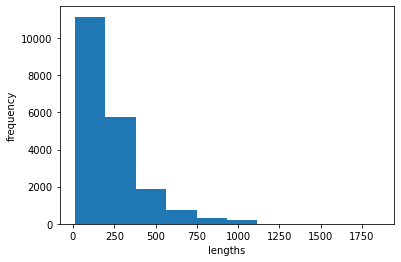

In [8]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.show()

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

In [10]:
print(train_seq.shape)

# 이제는 2차원이 됐음

(20000, 100)


In [11]:
print(train_seq[0])

# 패딩값이 0이 없는걸 보아 단어의 길이가 100보다는 길었을 것이다.

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [12]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [13]:
# 검증세트의 길이도 100으로 맞추기

val_seq = pad_sequences(val_input, maxlen = 100)

## 순환신경망 만들기

In [14]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))  # 앞서 샘플의 길이를 100으로 지정했기 때문에 100임 
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [15]:
train_oh = keras.utils.to_categorical(train_seq)

In [16]:
print(train_oh.shape)

(20000, 100, 500)


In [17]:
print(train_oh[0][0][:12])

# 열한번째 원소가 1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [18]:
val_oh = keras.utils.to_categorical(val_seq)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [21]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 37s 110ms/step - loss: 0.7034 - accuracy: 0.5088 - val_loss: 0.6889 - val_accuracy: 0.5316
Epoch 2/100
313/313 [==============================] - 33s 106ms/step - loss: 0.6797 - accuracy: 0.5601 - val_loss: 0.6614 - val_accuracy: 0.6076
Epoch 3/100
313/313 [==============================] - 33s 104ms/step - loss: 0.6454 - accuracy: 0.6352 - val_loss: 0.6320 - val_accuracy: 0.6540
Epoch 4/100
313/313 [==============================] - 32s 104ms/step - loss: 0.6154 - accuracy: 0.6736 - val_loss: 0.6039 - val_accuracy: 0.6876
Epoch 5/100
313/313 [==============================] - 33s 106ms/step - loss: 0.5834 - accuracy: 0.7085 - val_loss: 0.5746 - val_accuracy: 0.7164
Epoch 6/100
313/313 [==============================] - 33s 106ms/step - loss: 0.5575 - accuracy: 0.7321 - val_loss: 0.5516 - val_accuracy: 0.7376
Epoch 7/100
313/313 [==============================] - 33s 104ms/step - loss: 0.5362 - accuracy: 0.7476 - val_loss: 0.5365 -

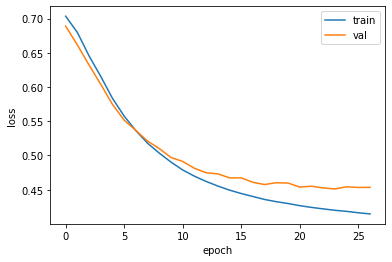

In [22]:
# 이 훈련은 27번째 에포크에서 조기종료 됨 검증세트에 대한 정확도는 약 80%로 매우 뛰어난 성능은 아니지만
# 감상평을 분류하는데 어느정도 성과를 내고 있다고 판단한다.
# 훈련손실과 검증 손실을 그래프로 그려서 훈련과정을 살펴보겠다.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 대략 20번째 에포크에서 감소가 둔해진다.

In [23]:
# 원핫인코딩은 훈련데이터가 커질수록 문제가 된다. 썩 좋지않다.

## 단어 임베딩을 사용하기

In [24]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))  # 500은 앞서 정의한 어휘사전의 크기, 16은 임베딩 벡터의 크기(원핫인코딩 보다 훨씬 작은 크기)
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [26]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 42s 131ms/step - loss: 0.6969 - accuracy: 0.5117 - val_loss: 0.6945 - val_accuracy: 0.5082
Epoch 2/100
313/313 [==============================] - 44s 141ms/step - loss: 0.6899 - accuracy: 0.5325 - val_loss: 0.6907 - val_accuracy: 0.5218
Epoch 3/100
313/313 [==============================] - 45s 144ms/step - loss: 0.6842 - accuracy: 0.5583 - val_loss: 0.6875 - val_accuracy: 0.5288
Epoch 4/100
313/313 [==============================] - 45s 143ms/step - loss: 0.6786 - accuracy: 0.5759 - val_loss: 0.6845 - val_accuracy: 0.5424
Epoch 5/100
313/313 [==============================] - 45s 144ms/step - loss: 0.6726 - accuracy: 0.5931 - val_loss: 0.6810 - val_accuracy: 0.5536
Epoch 6/100
313/313 [==============================] - 45s 145ms/step - loss: 0.6659 - accuracy: 0.6047 - val_loss: 0.6768 - val_accuracy: 0.5654
Epoch 7/100
313/313 [==============================] - 46s 146ms/step - loss: 0.6582 - accuracy: 0.6184 - val_loss: 0.6710 -

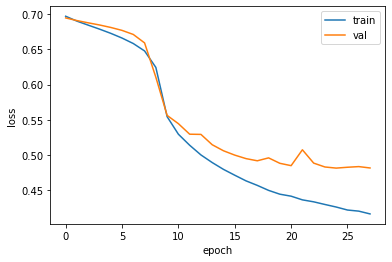

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()